In [1]:
import os
import sys
sys.path.append(os.getcwd().split('notebooks')[0])
FILE_DIR = os.getcwd().split('notebooks')[0]
from pathlib import Path
import torch
from torch import nn
import json
import pickle
import selfies as sf
import pandas as pd
import numpy as np
import pytorch_lightning as pl
import seaborn as sns
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from scipy.stats import linregress, pearsonr
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import DataLoader, TensorDataset, random_split
from src.models.components.vae import PropertyPredictor


# Functions from LIMO to translate SMILES into one-hot encodings:

def smiles_to_indices(smiles):
    encoding = [symbol_to_idx[symbol] for symbol in sf.split_selfies(sf.encoder(smiles))]
    return torch.tensor(encoding + [symbol_to_idx['[nop]'] for i in range(max_len - len(encoding))])


def smiles_to_one_hot(smiles):
    out = torch.zeros((max_len, len(symbol_to_idx)))
    for i, index in enumerate(smiles_to_indices(smiles)):
        out[i][index] = 1
    return out.flatten()

In [2]:
# We will use the same symbol encodings as the VAE and Diffusion Model are using to encode the molecules for training
# the property predictor. This is essential because during guidance, the predictor will receive one-hot encoded molecules
# from the VAE's decoder and their symbol arrangement must match the one the predictor was trained on.
symbol_to_idx = pickle.load(open(f'{FILE_DIR}/data/zinc250k/symbol_to_idx.pickle', "rb"))
idx_to_symbol = pickle.load(open(f'{FILE_DIR}/data/zinc250k/idx_to_symbol.pickle', "rb"))
max_len = pickle.load(open(f'{FILE_DIR}/data/zinc250k/dataset_max_len.pickle', "rb"))

In [3]:
# if you used docking/scripts/dlg2aff.py during the docking precedure to extract your affinities, then you should have
# a .csv file with smiles and their binding affinities (in a column labelled "affinity").
PROPERTY = 'affinity'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'You are running on the following device:    {device}')

You are running on the following device:    cuda


In [4]:
# specify a path to save model file, and plots
save_dir = f"{FILE_DIR}/checkpoints/property_predictors/{PROPERTY}/"

In [5]:
# load best checkpoint for evaluation
model = PropertyPredictor.load_from_checkpoint(save_dir + "/best.ckpt", in_dim=max_len * len(symbol_to_idx))
model.eval()
model = model.to(device)

In [6]:
# load validation batches that were not included in the training 
batch_1_x = torch.load(f'{FILE_DIR}/data/zinc250k/batched_one_hots_esr1/230000_x_batch.pt')
batch_1_y = torch.load('{FILE_DIR}/data/zinc250k/batched_one_hots_esr1/230000_y_batch.pt')

batch_2_x = torch.load(f'{FILE_DIR}/data/zinc250k/batched_one_hots_esr1/240000_x_batch.pt')
batch_2_y = torch.load(f'{FILE_DIR}/data/zinc250k/batched_one_hots_esr1/240000_y_batch.pt')

x = torch.cat([batch_1_x, batch_2_x])
print(x.shape)

y = torch.cat([batch_1_y, batch_2_y])
print(y.shape)

torch.Size([15593, 7776])
torch.Size([15593, 1])


/tmp/ipykernel_3932430/2541609042.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  batch_1_x = torch.load('/home/oestreichm/repos/DrugDiff/data/zinc250k/batched_one_hots/

In [8]:
# Calculate the predictions and get the correlation coefficient for the validation set
predictions = model(x.to(device)).detach().cpu().numpy().flatten()
# correlation between predicted and true values
correlation = linregress(predictions, y.detach().cpu().numpy().flatten()).rvalue
# calculate errors
mae = mean_absolute_error(y.detach().cpu().numpy(), predictions)
mse = mean_squared_error(y.detach().cpu().numpy(), predictions)
print(f'property predictor trained, correlation of r = {correlation}')
print(f'MAE = {mae}')
print(f'MSE = {mse}')


# specify a path to save model file, and plots
save_dir = save_dir + "/hyperparameter_search/"

# dynamic saving of dirs during hyperparam search
dir_num = 1
while True:
    model_save_location = os.path.join(save_dir, str(dir_num))
    if not os.path.exists(model_save_location):
        Path(model_save_location).mkdir(parents=True, exist_ok=True)
        break
    else:
        dir_num += 1

# lightening_log_dir = f"./{trainer.logger.log_dir}"
# print(f"lightning logs saved at {lightening_log_dir}")

property predictor trained, correlation of r = 0.8418575799052239
MAE = 0.037486109882593155
MSE = 0.002555588958784938


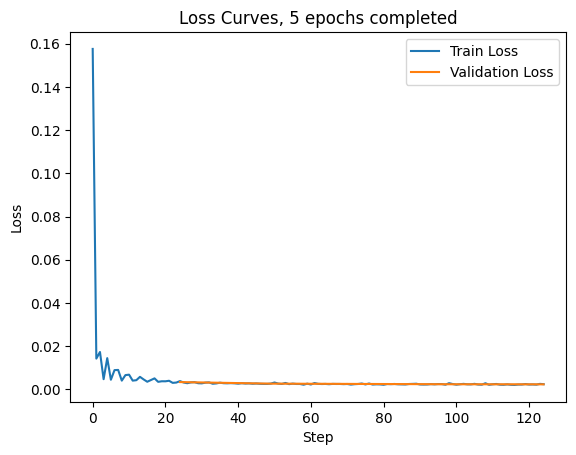

In [10]:
# fucncion to plot the loss logged across training epochs
def plot_losses_from_csv(file_path):
    data = pd.read_csv(file_path)
    
    # Extract the epochs from the csv file so losses can be plotted during training
    epochs = data["epoch"].unique()
    num_epochs = epochs[-1] + 1
    
    train_losses = data['train_loss']
    val_losses = data['val_loss']
    steps_train = data['step']
    steps_val = data['step']  # Add steps for validation

    # Find indices with valid training and validation losses
    valid_indices_train = ~np.isnan(train_losses)
    valid_indices_val = ~np.isnan(val_losses)
    
    # Filter out rows with NaN for train and val losses
    steps_train = steps_train[valid_indices_train]
    steps_val = steps_val[valid_indices_val]
    train_losses = train_losses[valid_indices_train]
    val_losses = val_losses[valid_indices_val]
    
    # Plot training and validation losses
    plt.plot(steps_train, train_losses, label='Train Loss')
    plt.plot(steps_val, val_losses, label='Validation Loss')

    plt.xlabel('Step')
    plt.ylabel('Loss')
    
    plt.title(f'Loss Curves, {num_epochs} epochs completed')

    plt.legend()
    plt.savefig(os.path.join(model_save_location, "train_val_loss.png"))

    return

plot_losses_from_csv(file_path=os.path.join(f'{FILE_DIR}/logs/lightning_logs/version_0', "metrics.csv"))

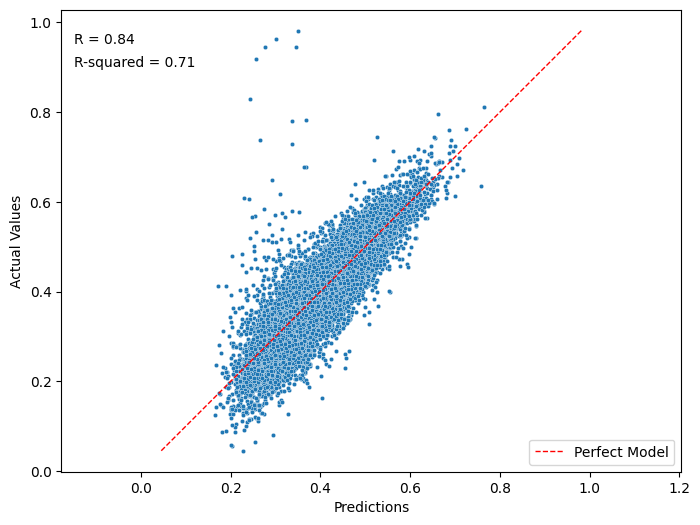

In [11]:
# Now, plot the predicted vs. the real values

# Create a DataFrame to store the data
data = pd.DataFrame({'y_pred': predictions,
                     'y_real': y.detach().cpu().numpy().flatten()})

data.to_csv(os.path.join(model_save_location, "predictions.csv"))

# Create a Seaborn plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='y_pred', y='y_real', s=10)

# Adjust axis limits based on the data
plt.ylim(data['y_real'].min(), data['y_real'].max())
plt.xlim(data['y_pred'].min(), data['y_pred'].max())
plt.axis('equal')

# Add text annotations
correlation_coefficient, _ = pearsonr(data['y_real'], data['y_pred'])
r_squared = r2_score(data['y_real'], data['y_pred'])
plt.text(
    0.02, 0.95, f'R = {correlation_coefficient:.2f}', fontsize=10, transform=plt.gca().transAxes,
    verticalalignment='top'
)
plt.text(
    0.02, 0.9, f'R-squared = {r_squared:.2f}', fontsize=10, transform=plt.gca().transAxes,
    verticalalignment='top'
)

# Add a diagonal line for a perfect model (line of equality)
x_min, x_max = data["y_pred"].min(), data["y_pred"].max()
y_min, y_max = data["y_real"].min(), data["y_real"].max()
line_x = np.linspace(min(x_min, y_min), max(x_max, y_max), 100)
plt.plot(line_x, line_x, linestyle='--', color='red', linewidth=1, label='Perfect Model')

# Label the x and y axes
plt.xlabel("Predictions")
plt.ylabel("Actual Values")

# Show the plot with custom text legends (no lines)
perfect_model_legend = plt.Line2D([], [], linestyle='--', color='red', label='Perfect Model', linewidth=1)
plt.legend(handles=[perfect_model_legend], loc='lower right')

# # Add a title to the plot (replace with your desired title)
# chemical_property = config["chemical_property_predicted"]
# plt.title(f"Predictor: {chemical_property}")

# Save the plot
plt.savefig(os.path.join(model_save_location, "performance.png"))